# Decision Making with VIKOR Method
Cong Son DUONG, Mohammed Adel DJELLOUL ABBOU, Nikethan NIMALAKUMARAN, Samar HAMDI

Teacher: Mostafa AMELI

Université Gustave Eiffel, GRETTIA, UC Berkeley

In [ ]:
# ! pip install numpy pandas matplotlib

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Step 0.1: Input Data

In [ ]:
num_criteria = int(input("Enter the number of criteria: "))
num_alternatives = int(input("Enter the number of alternatives: "))


# Generate Random Data
criteria_names = [f"Criterion {i+1}" for i in range(num_criteria)]

# Randomly assign criteria types (either "Max" (benefit) or "Min" (cost))
criteria_types = np.random.choice(["Max", "Min"], num_criteria)

# Create criteria DataFrame
criteria_df = pd.DataFrame({
    "name": criteria_names,
    "type": criteria_types
})

# Generate random decision matrix values (between 10 and 1000 for diversity)
decision_data = {
    "Alternative": [f"Alternative {i+1}" for i in range(num_alternatives)]
}
for crit in criteria_names:
    decision_data[crit] = np.random.randint(1, 100, num_alternatives)

# Convert to DataFrame
decision_df = pd.DataFrame(decision_data)

# Print generated data
print("\nGenerated Characteristics of Criteria Table:")
print(criteria_df)
print("\nGenerated Decision Matrix Table:")
print(decision_df)


Generated Characteristics of Criteria Table:
          name type
0  Criterion 1  Max
1  Criterion 2  Max
2  Criterion 3  Max

Generated Decision Matrix Table:
     Alternative  Criterion 1  Criterion 2  Criterion 3
0  Alternative 1          371          320          803
1  Alternative 2          829          967          987
2  Alternative 3          253          602          717


## Step 0.2: Determine weights using AHP

In [8]:
def ahp_weights(pairwise):
    """
    Compute AHP weights using the geometric mean method.
    """
    n = pairwise.shape[0]
    gm = np.prod(pairwise, axis=1)**(1/n)  # Geometric mean of each row
    weights = gm / np.sum(gm)
    return weights

In [ ]:
# Generate a random consistent pairwise comparison matrix
pairwise = np.random.rand(num_criteria, num_criteria)
pairwise = (pairwise + pairwise.T) / 2  # Make it symmetric
np.fill_diagonal(pairwise, 1)  # Set diagonal to 1

# Compute weights
weights_ahp = ahp_weights(pairwise)
criteria_df["weight_ahp"] = weights_ahp

print("\nAHP Weights for Criteria:")
print(criteria_df)


AHP Weights for Criteria:
          name type  weight_ahp
0  Criterion 1  Max    0.295978
1  Criterion 2  Max    0.339442
2  Criterion 3  Max    0.364580


## Step 1: Normalize the Decision Matrix

$f_{ij}(x) = \frac{x_{ij}}{\sqrt{\sum_{i=1}^{m} x_{ij}^2}}$


In [10]:
# Normalize the decision matrix based on the formula
def normalize_decision_matrix(decision_df):
    sum_squares = np.sqrt((decision_df.drop(columns=["Alternative"]) ** 2).sum())
    df_norm = decision_df.copy()
    for crit, const in sum_squares.items():
        df_norm[crit] = decision_df[crit] / const
    return df_norm

In [11]:
norm_decision_df = normalize_decision_matrix(decision_df)
print("Normalized Decision Matrix:")
norm_decision_df

Normalized Decision Matrix:


,Alternative,Criterion 1,Criterion 2,Criterion 3
0,Alternative 1,0.393504,0.270460,0.549811
1,Alternative 2,0.879286,0.817295,0.675795
2,Alternative 3,0.268347,0.508802,0.490927


## Step 2: Determine Best (Ideal) and Worst (Anti-Ideal) Values
For each criterion:
- If it's a "benefit" (Max), the best value is the Maximum; the worst is the minimum.
- If it's a "cost" (Min), the best value is the minimum; the worst is the Maximum.

In [12]:
def compute_ideal_worst_values(norm_decision_df, criteria_df):
    ideal = {}
    worst = {}

    for _, row in criteria_df.iterrows():
        crit = row["name"]
        crit_type = row["type"]
        vals = norm_decision_df[crit]

        if crit_type.lower() == "max":  # Benefit criteria
            ideal[crit] = vals.max()
            worst[crit] = vals.min()
        else:  # Cost criteria (Min)
            ideal[crit] = vals.min()
            worst[crit] = vals.max()

    return ideal, worst
ideal, worst = compute_ideal_worst_values(norm_decision_df, criteria_df)
print("Ideal (Best) and Worst (Anti-Ideal) Values:")
print("Ideal:", ideal)
print("Worst:", worst)

Ideal (Best) and Worst (Anti-Ideal) Values:
Ideal: {'Criterion 1': 0.8792862382536839, 'Criterion 2': 0.8172953972790842, 'Criterion 3': 0.6757948910229081}
Worst: {'Criterion 1': 0.26834670479877204, 'Criterion 2': 0.2704596971347538, 'Criterion 3': 0.49092698770357157}


## Step 3: Compute Deviation $d_{ij}$ for Each Alternative
- For cost (Min):  $d_{ij} = (f_{ij} - f^{*}_j) / (f^{-}_j - f^{*}_j)$
- For benefit (Max): $d_{ij} = (f^{*}_j - f_{ij}) / (f^{*}_j - f^{-}_j)$

In [13]:
def compute_deviations(norm_df, criteria_df, ideal, worst):
    deviations = {}  
    for i, row in norm_df.iterrows():
        d_row = {}
        for _, crit_row in criteria_df.iterrows():
            crit = crit_row["name"]
            crit_type = crit_row["type"]
            val = row[crit]
            if ideal[crit] == worst[crit]:
                d = 0  # Avoid division by zero
            else:
                if crit_type.lower() == "Max":
                    d = (ideal[crit] - val) / (ideal[crit] - worst[crit])
                else:  # Min
                    d = (val - ideal[crit]) / (worst[crit] - ideal[crit])
            d_row[crit] = d
        deviations[row["Alternative"]] = d_row
    return deviations

In [14]:
deviations = compute_deviations(norm_decision_df, criteria_df, ideal, worst)
print("\nDeviation d_ij for Each Alternative:")
for alt, d in deviations.items():
    print(f"{alt}: {d}")


Deviation d_ij for Each Alternative:
Alternative 1: {'Criterion 1': 0.7951388888888888, 'Criterion 2': 1.0, 'Criterion 3': 0.6814814814814812}
Alternative 2: {'Criterion 1': -0.0, 'Criterion 2': -0.0, 'Criterion 3': -0.0}
Alternative 3: {'Criterion 1': 1.0, 'Criterion 2': 0.564142194744977, 'Criterion 3': 1.0}


## Step 4: Compute S and R Indices
- S (group utility): $sum_j (w_j * d_{ij})$
- R (individual regret): $Max_j (w_j * d_{ij})$

In [15]:
def compute_S_R(deviations, criteria_df):
    S_dict = {}
    R_dict = {}
    for alt, d_dict in deviations.items():
        weighted = []
        for _, crit_row in criteria_df.iterrows():
            crit = crit_row["name"]
            w = crit_row["weight_ahp"]
            weighted.append(w * d_dict[crit])
        S_dict[alt] = np.sum(weighted)
        R_dict[alt] = np.max(weighted)
    return S_dict, R_dict

In [16]:
S_dict, R_dict = compute_S_R(deviations, criteria_df)
print("S and R Indices:")
for alt in decision_df["Alternative"]:
    print(f"{alt}: S = {S_dict[alt]:.3f}, R = {R_dict[alt]:.3f}")

S and R Indices:
Alternative 1: S = 0.823, R = 0.339
Alternative 2: S = 0.000, R = -0.000
Alternative 3: S = 0.852, R = 0.365


## Step 5: Compute Q Index and Rank Alternatives

$Q_i = \gamma \frac{(S_i - S^*)}{(S^- - S^*)} + (1 - \gamma) \frac{(R_i - R^*)}{(R^- - R^*)}$

Where:
- $S^* = \min_{i} \{ S_i \}$;  $S^- = \max_{i} \{ S_i \}$
- $R^* = \min_{i} \{ R_i \}$;  $R^- = \max_{i} \{ R_i \}$

In [17]:
def compute_q_index(S_dict, R_dict, decision_df, gamma=0.5):
    # Compute S* (Min of S), S^- (Max of S), R* (Min of R), R^- (Max of R)
    S_star, S_worst = min(S_dict.values()), max(S_dict.values())
    R_star, R_worst = min(R_dict.values()), max(R_dict.values())

    # Compute Q for each alternative using the VIKOR formula
    Q_dict = {}
    for alt in decision_df["Alternative"]:
        S_i, R_i = S_dict[alt], R_dict[alt]

        # Avoid division by zero
        S_diff = S_worst - S_star if S_worst != S_star else 1
        R_diff = R_worst - R_star if R_worst != R_star else 1

        # Compute Q index
        Q_dict[alt] = gamma * ((S_i - S_star) / S_diff) + (1 - gamma) * ((R_i - R_star) / R_diff)

    # Rank alternatives by Q index (lower is better)
    ranking = sorted(Q_dict.items(), key=lambda x: x[1])

    return Q_dict, ranking

# Call the function
Q_dict, ranking = compute_q_index(S_dict, R_dict, decision_df)

# Print ranking results
print("Ranking of Alternatives (Best to Worst):")
for rank, (alt, q_val) in enumerate(ranking, start=1):
    print(f"Rank {rank}: {alt} (Q = {q_val:.3f})")

Ranking of Alternatives (Best to Worst):
Rank 1: Alternative 2 (Q = 0.000)
Rank 2: Alternative 1 (Q = 0.949)
Rank 3: Alternative 3 (Q = 1.000)


# Computation Time Analysis

In [21]:
def run_vikor(n, m):
    criteria_names = [f"Criterion {i+1}" for i in range(n)]
    criteria_types = np.random.choice(["Max", "Min"], n)

    # Generate random decision matrix values
    decision_data = {
        "Alternative": [f"Alternative {i+1}" for i in range(m)]
    }
    for crit in criteria_names:
        decision_data[crit] = np.random.randint(1, 100, m)

    # Convert to DataFrame
    decision_df = pd.DataFrame(decision_data)
    criteria_df = pd.DataFrame({
        "name": criteria_names,
        "type": criteria_types
    })

    # Generate a random pairwise comparison matrix for AHP
    pairwise = np.random.rand(n, n)
    pairwise = (pairwise + pairwise.T) / 2  # Make symmetric
    np.fill_diagonal(pairwise, 1)  # Set diagonal to 1

    criteria_df["weight_ahp"] = ahp_weights(pairwise)

    start_time = time.time()

    norm_decision_df = normalize_decision_matrix(decision_df)
    ideal, worst = compute_ideal_worst_values(norm_decision_df, criteria_df)
    deviations = compute_deviations(norm_decision_df, criteria_df, ideal, worst)
    S_dict, R_dict = compute_S_R(deviations, criteria_df)
    compute_q_index(S_dict, R_dict, decision_df)
    
    return time.time() - start_time

In [22]:
n_values = range(1, 51)  # n from 1 to 50
m_values = range(1, 51)  # m from 1 to 50

# Measure computation time for varying n (with m=5)
time_n = []
for n in n_values:
    time_n.append(run_vikor(n, 5))

# Measure computation time for varying m (with n=5)
time_m = []
for m in m_values:
    time_m.append(run_vikor(5, m))

# Measure computation time for varying n and m (3D plot)
time_n_m = np.zeros((len(n_values), len(m_values)))
for i, n in enumerate(n_values):
    for j, m in enumerate(m_values):
        time_n_m[i, j] = run_vikor(n, m)

# Visualization

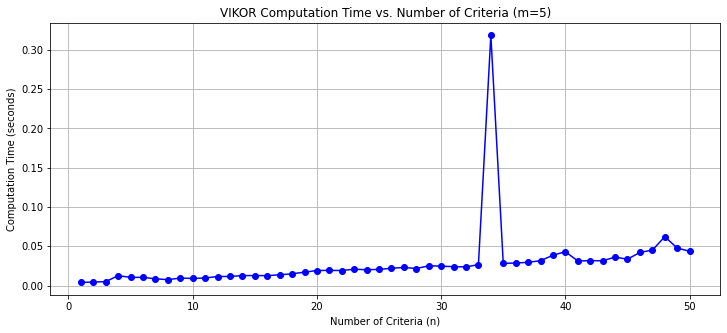

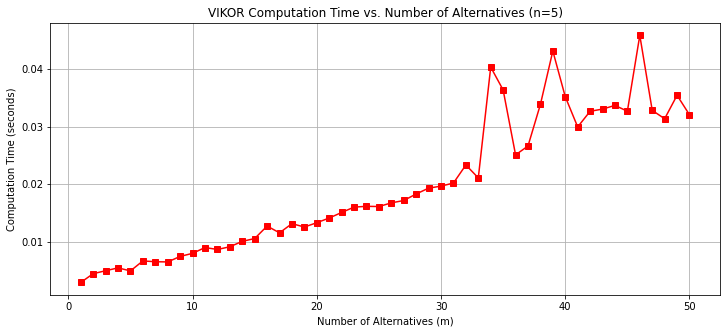

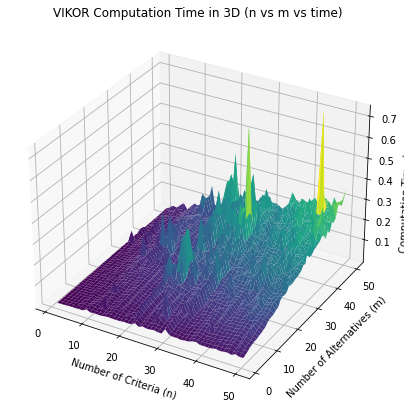

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(n_values, time_n, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Criteria (n)")
plt.ylabel("Computation Time (seconds)")
plt.title("VIKOR Computation Time vs. Number of Criteria (m=5)")
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(m_values, time_m, marker="s", linestyle="-", color="r")
plt.xlabel("Number of Alternatives (m)")
plt.ylabel("Computation Time (seconds)")
plt.title("VIKOR Computation Time vs. Number of Alternatives (n=5)")
plt.grid()
plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(n_values, m_values)
ax.plot_surface(X, Y, time_n_m.T, cmap="viridis")

ax.set_xlabel("Number of Criteria (n)")
ax.set_ylabel("Number of Alternatives (m)")
ax.set_zlabel("Computation Time (seconds)")
ax.set_title("VIKOR Computation Time in 3D (n vs m vs time)")
plt.show()